# Training BERT given mydataset

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
#creating dataset for BERT

AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 32

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'final_bert_dataset',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    shuffle=True,
    label_mode='categorical',
    seed=seed)
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'final_bert_dataset',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    shuffle=True,
    label_mode='categorical',
    seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'bert_dataset_with_test/test',
    batch_size=batch_size)

class_names = raw_train_ds.class_names

Found 2236 files belonging to 50 classes.
Using 1789 files for training.
Found 2236 files belonging to 50 classes.
Using 447 files for validation.
Found 250 files belonging to 50 classes.


In [4]:
#downloading preprocess model and Bert model

tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [5]:
#testing the preprocess model

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
#testing the BERT model

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print("----")
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print("----")
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print("----")
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print("----")
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
----
Pooled Outputs Shape:(1, 768)
----
Pooled Outputs Values:[-0.9216116  -0.39333072 -0.5387545   0.68229514  0.43816    -0.14001045
  0.8773655   0.26032025 -0.6307239  -0.9999657  -0.26284206  0.85081995]
----
Sequence Outputs Shape:(1, 128, 768)
----
Sequence Outputs Values:[[ 0.19436876  0.2509688   0.19051474 ... -0.24828759  0.38553947
   0.1329951 ]
 [-0.594566   -0.39402184  0.2527799  ... -0.76929235  1.155868
   0.3248655 ]
 [ 0.00628068 -0.15767251  0.5466162  ... -0.17402229  0.6029077
   0.426998  ]
 ...
 [ 0.2200106  -0.2089951   0.53832436 ...  0.2474025   0.182352
  -0.4443757 ]
 [ 0.01104671 -0.44551998  0.35960633 ...  0.3172928   0.23566316
  -0.6308622 ]
 [ 0.29332292 -0.10542406  0.6111842  ...  0.20748322  0.14445798
  -0.35356426]]


In [7]:
#creating the classification model (including preprocess, bert encoder, classifier)

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    
    Dense2 = tf.keras.layers.Dense(192, activation='relu', name='dense2')(net)
    
    classifier = tf.keras.layers.Dense(50, activation='softmax', name='classifier')(Dense2)
    
    return tf.keras.Model(text_input, classifier)

In [8]:
#creating an instance of the full model which is named classifier_model

classifier_model = build_classifier_model()

tf.keras.utils.plot_model(classifier_model)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [9]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

In [10]:
loss = tf.keras.losses.CategoricalCrossentropy()
metrics = tf.keras.metrics.CategoricalAccuracy('accuracy')

epochs = 40

# defining the new optimizer

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)

classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [11]:
print(f'Training model with {tfhub_handle_encoder}')

filepath = "d:\model-improvement-{epoch:02d}-{accuracy:.2f}"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, save_weights_only=False)
callbacks_list = [checkpoint]

history = classifier_model.fit(x=train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks_list)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4
Epoch 1/40
112/112 [==============================] - ETA: 0s - loss: 3.9535 - accuracy: 0.0263
Epoch 1: accuracy improved from -inf to 0.02627, saving model to d:\model-improvement-01-0.03


112/112 [==============================] - 60s 443ms/step - loss: 3.9535 - accuracy: 0.0263 - val_loss: 3.8681 - val_accuracy: 0.0380
Epoch 2/40
112/112 [==============================] - ETA: 0s - loss: 3.6985 - accuracy: 0.0883
Epoch 2: accuracy improved from 0.02627 to 0.08832, saving model to d:\model-improvement-02-0.09


112/112 [==============================] - 48s 427ms/step - loss: 3.6985 - accuracy: 0.0883 - val_loss: 3.5492 - val_accuracy: 0.1544
Epoch 3/40
112/112 [==============================] - ETA: 0s - loss: 3.2902 - accuracy: 0.2197
Epoch 3: accuracy improved from 0.08832 to 0.21968, saving model to d:\model-improvement-03-0.22


112/112 [==============================] - 49s 437ms/step - loss: 3.2902 - accuracy: 0.2197 - val_loss: 3.1931 - val_accuracy: 0.2125
Epoch 4/40
112/112 [==============================] - ETA: 0s - loss: 2.8557 - accuracy: 0.3359
Epoch 4: accuracy improved from 0.21968 to 0.33594, saving model to d:\model-improvement-04-0.34


112/112 [==============================] - 50s 450ms/step - loss: 2.8557 - accuracy: 0.3359 - val_loss: 2.8767 - val_accuracy: 0.3065
Epoch 5/40
112/112 [==============================] - ETA: 0s - loss: 2.4581 - accuracy: 0.4433
Epoch 5: accuracy improved from 0.33594 to 0.44326, saving model to d:\model-improvement-05-0.44


112/112 [==============================] - 53s 474ms/step - loss: 2.4581 - accuracy: 0.4433 - val_loss: 2.6197 - val_accuracy: 0.3535
Epoch 6/40
112/112 [==============================] - ETA: 0s - loss: 2.1065 - accuracy: 0.5646
Epoch 6: accuracy improved from 0.44326 to 0.56456, saving model to d:\model-improvement-06-0.56


112/112 [==============================] - 50s 450ms/step - loss: 2.1065 - accuracy: 0.5646 - val_loss: 2.4641 - val_accuracy: 0.3826
Epoch 7/40
112/112 [==============================] - ETA: 0s - loss: 1.8171 - accuracy: 0.6238
Epoch 7: accuracy improved from 0.56456 to 0.62381, saving model to d:\model-improvement-07-0.62


112/112 [==============================] - 50s 442ms/step - loss: 1.8171 - accuracy: 0.6238 - val_loss: 2.2105 - val_accuracy: 0.4609
Epoch 8/40
112/112 [==============================] - ETA: 0s - loss: 1.5551 - accuracy: 0.6976
Epoch 8: accuracy improved from 0.62381 to 0.69760, saving model to d:\model-improvement-08-0.70


112/112 [==============================] - 50s 441ms/step - loss: 1.5551 - accuracy: 0.6976 - val_loss: 2.0591 - val_accuracy: 0.4989
Epoch 9/40
112/112 [==============================] - ETA: 0s - loss: 1.3419 - accuracy: 0.7451
Epoch 9: accuracy improved from 0.69760 to 0.74511, saving model to d:\model-improvement-09-0.75


112/112 [==============================] - 49s 437ms/step - loss: 1.3419 - accuracy: 0.7451 - val_loss: 1.9875 - val_accuracy: 0.5034
Epoch 10/40
112/112 [==============================] - ETA: 0s - loss: 1.1178 - accuracy: 0.7971
Epoch 10: accuracy improved from 0.74511 to 0.79709, saving model to d:\model-improvement-10-0.80


112/112 [==============================] - 50s 444ms/step - loss: 1.1178 - accuracy: 0.7971 - val_loss: 1.8624 - val_accuracy: 0.5570
Epoch 11/40
112/112 [==============================] - ETA: 0s - loss: 0.9284 - accuracy: 0.8530
Epoch 11: accuracy improved from 0.79709 to 0.85299, saving model to d:\model-improvement-11-0.85


112/112 [==============================] - 49s 437ms/step - loss: 0.9284 - accuracy: 0.8530 - val_loss: 1.7936 - val_accuracy: 0.5638
Epoch 12/40
112/112 [==============================] - ETA: 0s - loss: 0.7643 - accuracy: 0.8927
Epoch 12: accuracy improved from 0.85299 to 0.89268, saving model to d:\model-improvement-12-0.89


112/112 [==============================] - 50s 443ms/step - loss: 0.7643 - accuracy: 0.8927 - val_loss: 1.7653 - val_accuracy: 0.5593
Epoch 13/40
112/112 [==============================] - ETA: 0s - loss: 0.6367 - accuracy: 0.9156
Epoch 13: accuracy improved from 0.89268 to 0.91560, saving model to d:\model-improvement-13-0.92


112/112 [==============================] - 49s 439ms/step - loss: 0.6367 - accuracy: 0.9156 - val_loss: 1.7255 - val_accuracy: 0.5794
Epoch 14/40
112/112 [==============================] - ETA: 0s - loss: 0.5118 - accuracy: 0.9458
Epoch 14: accuracy improved from 0.91560 to 0.94578, saving model to d:\model-improvement-14-0.95


112/112 [==============================] - 50s 446ms/step - loss: 0.5118 - accuracy: 0.9458 - val_loss: 1.6970 - val_accuracy: 0.5861
Epoch 15/40
112/112 [==============================] - ETA: 0s - loss: 0.4315 - accuracy: 0.9558
Epoch 15: accuracy improved from 0.94578 to 0.95584, saving model to d:\model-improvement-15-0.96


112/112 [==============================] - 49s 438ms/step - loss: 0.4315 - accuracy: 0.9558 - val_loss: 1.6698 - val_accuracy: 0.5973
Epoch 16/40
112/112 [==============================] - ETA: 0s - loss: 0.3649 - accuracy: 0.9670
Epoch 16: accuracy improved from 0.95584 to 0.96702, saving model to d:\model-improvement-16-0.97


112/112 [==============================] - 50s 446ms/step - loss: 0.3649 - accuracy: 0.9670 - val_loss: 1.6753 - val_accuracy: 0.5705
Epoch 17/40
112/112 [==============================] - ETA: 0s - loss: 0.3166 - accuracy: 0.9676
Epoch 17: accuracy improved from 0.96702 to 0.96758, saving model to d:\model-improvement-17-0.97


112/112 [==============================] - 49s 437ms/step - loss: 0.3166 - accuracy: 0.9676 - val_loss: 1.6634 - val_accuracy: 0.5973
Epoch 18/40
112/112 [==============================] - ETA: 0s - loss: 0.2744 - accuracy: 0.9698
Epoch 18: accuracy improved from 0.96758 to 0.96982, saving model to d:\model-improvement-18-0.97


112/112 [==============================] - 50s 448ms/step - loss: 0.2744 - accuracy: 0.9698 - val_loss: 1.7175 - val_accuracy: 0.5749
Epoch 19/40
112/112 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9698
Epoch 19: accuracy did not improve from 0.96982
112/112 [==============================] - 37s 330ms/step - loss: 0.2470 - accuracy: 0.9698 - val_loss: 1.7069 - val_accuracy: 0.5772
Epoch 20/40
112/112 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9721
Epoch 20: accuracy improved from 0.96982 to 0.97205, saving model to d:\model-improvement-20-0.97


112/112 [==============================] - 49s 441ms/step - loss: 0.2179 - accuracy: 0.9721 - val_loss: 1.7164 - val_accuracy: 0.5794
Epoch 21/40
112/112 [==============================] - ETA: 0s - loss: 0.1987 - accuracy: 0.9715
Epoch 21: accuracy did not improve from 0.97205
112/112 [==============================] - 37s 330ms/step - loss: 0.1987 - accuracy: 0.9715 - val_loss: 1.7432 - val_accuracy: 0.5817
Epoch 22/40
112/112 [==============================] - ETA: 0s - loss: 0.1811 - accuracy: 0.9726
Epoch 22: accuracy improved from 0.97205 to 0.97261, saving model to d:\model-improvement-22-0.97


112/112 [==============================] - 50s 452ms/step - loss: 0.1811 - accuracy: 0.9726 - val_loss: 1.7294 - val_accuracy: 0.5794
Epoch 23/40
112/112 [==============================] - ETA: 0s - loss: 0.1712 - accuracy: 0.9726
Epoch 23: accuracy did not improve from 0.97261
112/112 [==============================] - 37s 330ms/step - loss: 0.1712 - accuracy: 0.9726 - val_loss: 1.7396 - val_accuracy: 0.5794
Epoch 24/40
112/112 [==============================] - ETA: 0s - loss: 0.1601 - accuracy: 0.9721
Epoch 24: accuracy did not improve from 0.97261
112/112 [==============================] - 37s 333ms/step - loss: 0.1601 - accuracy: 0.9721 - val_loss: 1.7398 - val_accuracy: 0.5839
Epoch 25/40
112/112 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9715
Epoch 25: accuracy did not improve from 0.97261
112/112 [==============================] - 45s 400ms/step - loss: 0.1525 - accuracy: 0.9715 - val_loss: 1.7549 - val_accuracy: 0.5839
Epoch 26/40
112/112 [========

112/112 [==============================] - 60s 541ms/step - loss: 0.1237 - accuracy: 0.9732 - val_loss: 1.8232 - val_accuracy: 0.5973
Epoch 33/40
112/112 [==============================] - ETA: 0s - loss: 0.1216 - accuracy: 0.9737
Epoch 33: accuracy improved from 0.97317 to 0.97373, saving model to d:\model-improvement-33-0.97


112/112 [==============================] - 50s 442ms/step - loss: 0.1216 - accuracy: 0.9737 - val_loss: 1.8403 - val_accuracy: 0.6063
Epoch 34/40
112/112 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9737
Epoch 34: accuracy did not improve from 0.97373
112/112 [==============================] - 37s 328ms/step - loss: 0.1202 - accuracy: 0.9737 - val_loss: 1.8462 - val_accuracy: 0.5906
Epoch 35/40
112/112 [==============================] - ETA: 0s - loss: 0.1182 - accuracy: 0.9737
Epoch 35: accuracy did not improve from 0.97373
112/112 [==============================] - 37s 330ms/step - loss: 0.1182 - accuracy: 0.9737 - val_loss: 1.8512 - val_accuracy: 0.5906
Epoch 36/40
112/112 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9726
Epoch 36: accuracy did not improve from 0.97373
112/112 [==============================] - 37s 331ms/step - loss: 0.1160 - accuracy: 0.9726 - val_loss: 1.8536 - val_accuracy: 0.5996
Epoch 37/40
112/112 [========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


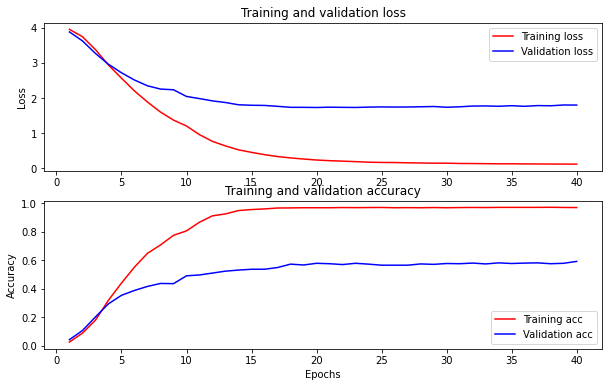

In [12]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [14]:
# classifier_model.save("behterin_model", include_optimizer=False)

In [15]:
# loaded_model = tf.keras.models.load_model('behterin_model')

In [3]:
loaded_model = tf.keras.models.load_model('models/192/model-improvement-33-0.97_Dense192_0.2Val_noDrop')

In [4]:
text_test = ['this is such an amazing movie!']
myTensor = tf.convert_to_tensor(text_test, dtype=tf.string)

###################################################################################################
###################################################################################################
# The model to get embbedings (intermediate_layer_model)

intermediate_layer_model = tf.keras.Model(inputs=loaded_model.get_layer("text").input,
                                       outputs=loaded_model.get_layer("dense2").output)
###################################################################################################
###################################################################################################


intermediate_layer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

# Mydataset embbedings

In [5]:
import pandas as pd
import xlsxwriter
import numpy as np

In [6]:
data = pd.read_csv(r'C:\Users\MOHSEN-ASUS\JupyterProjects\bert classification\final_dataset_for_bert.csv')

In [7]:
embbeding_size = 192

In [8]:
dataset_labels = np.array([])

In [9]:
dataset_empedings = np.zeros([1, embbeding_size])
dataset_labels = np.array([])
j = 0

for i in data["text"]:
    
    dataset_labels = np.append(dataset_labels, data["class"][j])
    
    txtTensor = tf.convert_to_tensor([i], dtype=tf.string)
    intermediate_output = intermediate_layer_model(txtTensor)
    
    sentence_embeding = intermediate_output.numpy()
    #print(sentence_embeding.shape)
    dataset_empedings = np.append(dataset_empedings, sentence_embeding, axis=0)
    
    j += 1


dataset_empedings = np.delete(dataset_empedings, 0, 0)

In [10]:
dataset_empedings.shape

(2237, 192)

In [11]:
dataset_labels.shape

(2237,)

# Embbedings view on T-SNE

In [12]:
from sklearn.manifold import TSNE
import seaborn as sns

In [13]:
x = dataset_empedings
y = dataset_labels 

tsne = TSNE(n_components=2, verbose=1, random_state=123)
z = tsne.fit_transform(x)

C:\Users\MOHSEN-ASUS\.conda\envs\piptext\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\MOHSEN-ASUS\.conda\envs\piptext\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2237 samples in 0.001s...
[t-SNE] Computed neighbors for 2237 samples in 0.129s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2237
[t-SNE] Computed conditional probabilities for sample 2000 / 2237
[t-SNE] Computed conditional probabilities for sample 2237 / 2237
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 47.458542
[t-SNE] KL divergence after 1000 iterations: 0.285943


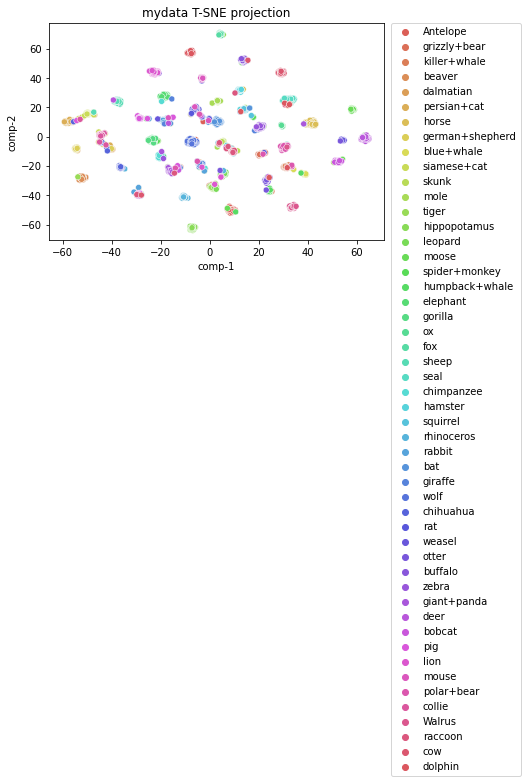

In [14]:
df = pd.DataFrame()
df["y"] = y
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 50),
                data=df).set(title="mydata T-SNE projection")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

plt.savefig('filename.png', dpi=500)

# TSNE for each class embbedings

In [104]:
import pandas as pd
import xlsxwriter
import numpy as np

data = pd.read_csv(r'C:\Users\MOHSEN-ASUS\JupyterProjects\bert classification\final_dataset_for_bert.csv')

In [111]:
def get_BERTembbedings(text, model):
    
    text_tensor = tf.convert_to_tensor(text, dtype=tf.string)
    model_output = model(text_tensor)
    
    return model_output["pooled_output"]

In [ ]:
def save_plot_TSNE(x, label, file_png):
    
    print(x.shape)
    print(label)
    
    y = np.array([])
    for i in x:
        y = np.append(y, label)
    
    tsne = TSNE(n_components=2, verbose=1, random_state=123)
    z = tsne.fit_transform(x)
    
    df = pd.DataFrame()
    df["y"] = y
    df["comp-1"] = z[:,0]
    df["comp-2"] = z[:,1]

    sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(),
                    palette=sns.color_palette("hls", 50),
                    data=df).set(title="mydata T-SNE projection")
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    plt.savefig(file_png, dpi=300)

In [127]:
def TSNE_each_classEmbbeding(dataset, BERT, embbeding_size=768):
    
    # you should know the column name (in this case the name is "class") which has class values
    class_names = data["class"].unique()
    
    for i in class_names:
        
        # getting all of the texts belong to class i
        class_texts = dataset[dataset["class"] == i]
        
        # in the line below i am creating a zero array to append my embbedings to it (i dont know how to do it without creating a zero)
        class_texts_embbedings = np.zeros([1, embbeding_size])
        
        for j in class_texts:
            
            # obtaining embbedings of class i texts using "get_BERTembbedings" and appending them to an array
            class_texts_embbedings = np.append(get_BERTembbedings(j, BERT), class_texts_embbedings, axis=0)
        
        # deleting the zero array from the first row
        class_texts_embbedings = np.delete(class_texts_embbedings, 0, 0)
        
        # saving TSNE plot of each class embbedings
        save_plot_TSNE(class_texts_embbedings, i, i)
        

In [128]:
TSNE_each_classEmbbeding(data, intermediate_layer_model)

ValueError: Exception encountered when calling layer "preprocessing" (type KerasLayer).

Could not find matching concrete function to call loaded from the SavedModel. Got:
  Positional arguments (2 total):
    * Tensor("inputs:0", shape=(), dtype=string)
    * False
  Keyword arguments: {}

 Expected these arguments to match one of the following 2 option(s):

Option 1:
  Positional arguments (2 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
    * False
  Keyword arguments: {}

Option 2:
  Positional arguments (2 total):
    * TensorSpec(shape=(None,), dtype=tf.string, name='inputs')
    * True
  Keyword arguments: {}

Call arguments received:
  • args=('tf.Tensor(shape=(), dtype=string)',)
  • kwargs={'training': 'False'}

In [113]:
class_names = data["class"].unique()
class_names.shape

(50,)

In [123]:
behnam = data[data["class"] == class_names[0]]
label = behnam["class"][0]
print(label)
y = np.array([])
for i in behnam["text"]:
    y = np.append(y, label)
    
y.shape

Antelope


(59,)

# Test blocks

In [40]:
test_text = "behnam"
probs = loaded_model.predict([test_text])

In [42]:
print(probs)

[[9.8559868e-01 3.5122331e-04 2.4117078e-04 4.5487666e-04 9.1990281e-05
  3.6703621e-04 2.6911215e-04 8.9518646e-05 5.6429714e-04 1.1563933e-04
  2.2724384e-04 3.6333693e-04 6.1131787e-04 1.8161589e-04 4.4743231e-04
  2.6473208e-04 7.7458040e-05 3.5198613e-05 1.2694254e-03 4.7917501e-04
  1.1139001e-04 3.1529050e-04 5.9277413e-04 1.2952139e-04 4.4515467e-04
  1.2069105e-04 6.0655686e-05 4.8951019e-04 7.6888617e-05 1.5119322e-04
  3.9288410e-04 8.4487263e-05 6.0229190e-04 1.9582360e-04 4.5138022e-05
  6.7228073e-05 9.5488504e-05 6.8909238e-04 1.4111183e-04 3.5351730e-04
  2.3887304e-04 1.0730186e-04 4.8800441e-05 3.9194722e-04 7.1938754e-05
  2.6265942e-04 3.0520180e-04 1.2587366e-04 6.4275716e-04 5.4395752e-04]]


In [10]:
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

NameError: name 'epochs' is not defined

In [ ]:
#optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)

In [ ]:
# original optimizer
####################################################################################
# steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)

# init_lr = 3e-5
# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')
####################################################################################